# **Colombian media during the 2021 protests - Analysis with NLP**

Dataset of news collected and voted in the 'Gravedad' and 'Sesgo' categories. The labels used for the analysis will be defined by the Mode on the votes for each observation.

### **Elaborado por:** Samuel Vasco González y Daniela Andrea Torres Gómez

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras.layers import Embedding,Dense,Input,Dropout, LSTM, Activation, Bidirectional, Conv1D, GlobalMaxPooling1D,SpatialDropout1D,GlobalAveragePooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.utils import to_categorical #para el one hot encoding
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
np.random.seed(5)

# *Gravedad de la Noticia*

# Datathon segundo modelo

In [ ]:
!pip install -U -q PyDrive
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
# Read files from Drive 
downloaded = drive.CreateFile({'id':"1tXkBYVQ6FKg0TSudTkFIfxFWeV2TJz14"})   # replace the id with id of file you want to access
downloaded.GetContentFile('IdentificacionSesgo-DataSet.csv')        

In [ ]:
dataset = pd.read_csv('IdentificacionSesgo-DataSet.csv')
dataset.head()

,Item (Texto),Gravedad,Sesgo,Nombre del Equipo
0,"Las protestas, sin precedentes, ya completan c...","2,2,2,2,3,2,2,2","1,-1,1,1,-1,1,0,0",Sample
1,"Antes rivales irreconciliables en las canchas,...","1,1,2,0,0,2,1,1,1,0","1,0,0,1,0,0,0,0,0",Sample
2,Una patrullera de la Policía Nacional denunció...,"3,3,3,3,3,3,3,3,3","1,1,1,1,1,1,1,1,1",Sample
3,"A simple vista, todo lo que ha dicho Petro es ...","1,0,0,1,1,0,1,1","-1,0,1,1,1,1,1,1",Sample
4,Durante los últimos 26 días desde que se convo...,"3,3,3,3,3,3,3,3,3","0,-1,0,0,0,0,0,0,0",Sample


In [ ]:
# Import dataset and data clean: 
#-----------------------------------------------------------------

#dataset=pd.read_csv("/content/drive/Shareddrives/Las_maquinas/Last_IdentificacionSesgo - DataSet.csv")
dataset=dataset.drop("Nombre del Equipo",axis=1)
dataset['GravedadMode'] = dataset['Gravedad'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
dataset['SesgoMode'] = dataset['Sesgo'].str.split(',',expand=True).mode(axis=1, numeric_only=False, dropna=True)[0]
dataset2=dataset.drop(["Gravedad","Sesgo"],axis=1)
dataset2.head()

,Item (Texto),GravedadMode,SesgoMode
0,"Las protestas, sin precedentes, ya completan c...",2,1
1,"Antes rivales irreconciliables en las canchas,...",1,0
2,Una patrullera de la Policía Nacional denunció...,3,1
3,"A simple vista, todo lo que ha dicho Petro es ...",1,1
4,Durante los últimos 26 días desde que se convo...,3,0


In [ ]:
# Arrays of the labels and features

Gravedad=dataset2["GravedadMode"].astype(int).values
Sesgo=dataset2["SesgoMode"].astype(int).values
Texto=dataset2["Item (Texto)"].values

nuevo_texto=[]
for i in range(len(Texto)):
  # Se convierte todo el texto a minúsculas
  nuevo_texto.append(Texto[i].lower())
  # Eliminación de signos de puntuación
  regex = '[\\!\\¡\\"\\#\\$\\%\\&\\\'\\(\\)\\*\\+\\,\\-\\.\\/\\:\\;\\<\\=\\>\\¿\\?\\@\\[\\\\\\]\\^_\\`\\{\\|\\}\\~\\”\\“\\…]'
  nuevo_texto[i] = re.sub(regex , '', nuevo_texto[i])

In [ ]:
#Division dataset en entrenamiento y test
Texto_train, Texto_test, Gravedad_train, Gravedad_test,Sesgo_train, Sesgo_test = train_test_split(nuevo_texto, Gravedad, Sesgo, test_size=0.1, random_state=5)

In [ ]:
#Tokenizar:
#Creating a dictionary that coding each word from text like number
vocab_size = 10000
max_length = 300 
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"


tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# fitting tokenizer only to training set
tokenizer.fit_on_texts(Texto_train)

word_index = tokenizer.word_index

# creating training sequences and padding them
traning_sequences = tokenizer.texts_to_sequences(Texto_train)
training_padded = pad_sequences(traning_sequences,maxlen = max_length,
                                padding = padding_type,
                                truncating=trunc_type,
                                )

# creating  testing sequences and padding them using same tokenizer
testing_sequences = tokenizer.texts_to_sequences(Texto_test)
testing_padded = pad_sequences(testing_sequences,maxlen = max_length,
                                padding = padding_type,
                                truncating=trunc_type,
                                )

In [ ]:
# Creating neural network 

def Neural_Network(input_shape,vocab_size=10000): 
      
    # Define sentence_indices as the input of the graph.
    sentence_indices = Input(shape=input_shape,dtype='int32')

    # Add embedding layer
    #The Embedding layer is initialized with random weights and will learn an 
    #embedding for all of the words in the training dataset.
    embeddings = Embedding(vocab_size,300,trainable = True)(sentence_indices) 

    # Add Spatial Dropout of 0.2  
    X=SpatialDropout1D (0.2)(embeddings)

    # Add Convolution 1D layer Filter=300, Kernel_size=4  
    X=Conv1D(300,4,padding="valid",activation="relu",strides=1)(X)

    # Add GlobalMaxPooling1D layer
    X=GlobalMaxPooling1D()(X)

    # Add Dense layer
    X=Dense (300, activation = 'relu')(X)

    # Add dropout with a probability of 0.2
    X = Dropout(rate=0.2)(X)

    # Propagate X through a Dense layer with 4 units
    #Converts a vector of numbers into a vector of probabilities, where the 
    #probabilities of each value are proportional to the relative scale of each value in the vector.
    out = Dense(4,activation = 'softmax')(X) 
    
    # Create Model instance which converts sentence_indices into X.
    model = Model(inputs=sentence_indices,outputs=out)
    
    
    return model

In [ ]:
# Calling the model with our data
model = Neural_Network((300,))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 300, 300)          3000000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 300, 300)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 297, 300)          360300    
_________________________________________________________________
global_max_pooling1d (Global (None, 300)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               90300     
_________________________________________________________________
dropout (Dropout)            (None, 300)               0     

In [ ]:
# Using Adamax optimizer and compile the model.
#based on the infinity norm. Adamax is sometimes superior to adam, specially in models with embeddings.
opt = Adamax(learning_rate=0.0095, beta_1=0.9, beta_2=0.999, decay=0.09)

#categorical_crossentropy for multi-class classification model where there are two or more output labels.
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
#Converting sentences to padded sequence
X_train = training_padded 
X_test = testing_padded

# one_hot encoding
#Technique for encoding categorical variables in binary values. Where 0 mean doesn't 
#belong at label and 1 mean yes belong. The output is a matrix.

# one hot encode Gravedad train
Gravedad_train_encoded = to_categorical(Gravedad_train)

# one hot encode Gravedad test
Gravedad_test_encoded = to_categorical(Gravedad_test)


In [ ]:
# Fitting the model

history = model.fit(X_train, Gravedad_train_encoded, epochs = 20, batch_size = 32, shuffle=True, validation_split=0.1)

Epoch 1/20
6/6 [==============================] - 4s 413ms/step - loss: 1.6370 - accuracy: 0.3314 - val_loss: 1.3086 - val_accuracy: 0.3500
Epoch 2/20
6/6 [==============================] - 2s 383ms/step - loss: 1.3602 - accuracy: 0.3600 - val_loss: 1.3230 - val_accuracy: 0.3500
Epoch 3/20
6/6 [==============================] - 2s 370ms/step - loss: 1.2400 - accuracy: 0.5943 - val_loss: 1.3680 - val_accuracy: 0.1500
Epoch 4/20
6/6 [==============================] - 2s 386ms/step - loss: 1.1572 - accuracy: 0.6857 - val_loss: 1.3866 - val_accuracy: 0.1500
Epoch 5/20
6/6 [==============================] - 2s 383ms/step - loss: 1.0683 - accuracy: 0.7371 - val_loss: 1.3793 - val_accuracy: 0.2000
Epoch 6/20
6/6 [==============================] - 2s 386ms/step - loss: 0.9586 - accuracy: 0.8400 - val_loss: 1.3718 - val_accuracy: 0.3000
Epoch 7/20
6/6 [==============================] - 2s 373ms/step - loss: 0.8579 - accuracy: 0.8629 - val_loss: 1.3661 - val_accuracy: 0.4000
Epoch 8/20
6/6 [====

In [ ]:
# Evaluating the model

loss, gravedad_acc  = model.evaluate(X_test,Gravedad_test_encoded)
print("gravedad accuracy = %s " % (gravedad_acc))


1/1 [==============================] - 0s 92ms/step - loss: 1.2605 - accuracy: 0.5000
gravedad accuracy = 0.5 


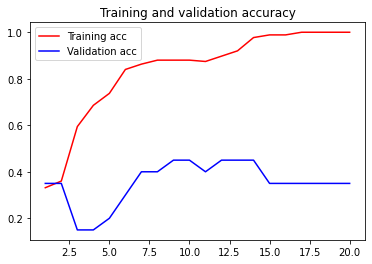

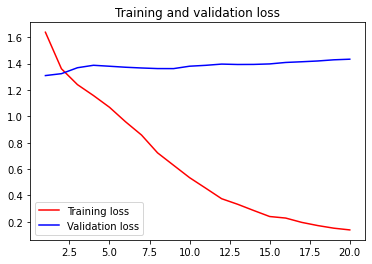

In [ ]:
# Visualizating the performance of the model 

acc_gravedad = history.history['accuracy']
val_acc_gravedad = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc_gravedad) + 1)
plt.plot(epochs, acc_gravedad, 'r', label='Training acc')
plt.plot(epochs, val_acc_gravedad, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Accuracy: 0.5, Recall: 0.5
              precision    recall  f1-score   support

           0       1.00      0.17      0.29         6
           1       1.00      0.20      0.33         5
           2       1.00      0.60      0.75         5
           3       0.35      1.00      0.52         6

    accuracy                           0.50        22
   macro avg       0.84      0.49      0.47        22
weighted avg       0.82      0.50      0.47        22



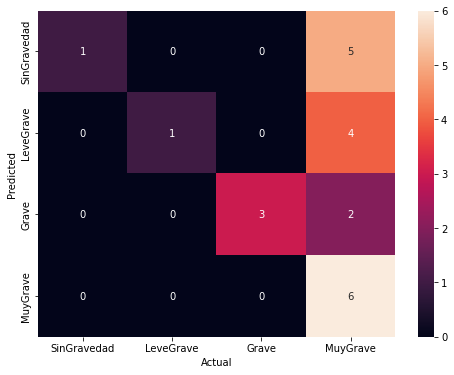

In [ ]:
# Metrics: Accuracy, recall and confusion matrix for Gravedad label

y_pred_gravedad =model.predict(X_test)

gravedad_pred = np.argmax(y_pred_gravedad,axis=1)
gravedad_true = Gravedad_test

recall_gravedad=recall_score(gravedad_true, gravedad_pred,average='micro')

print("Accuracy: {:.2}, Recall: {}".format(gravedad_acc,recall_gravedad))

print(classification_report(gravedad_true, gravedad_pred))

conf_mat2 = confusion_matrix(gravedad_true, gravedad_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat2, annot=True, fmt='d', xticklabels=["SinGravedad","LeveGrave","Grave","MuyGrave"],yticklabels=["SinGravedad","LeveGrave","Grave","MuyGrave"])
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()

----

# **MACHINE LEARNING MODEL**


## Exploratory Analysis

In [ ]:
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import chi2
from sklearn.model_selection import cross_val_score

2    65
3    65
1    57
0    30
Name: GravedadMode, dtype: int64

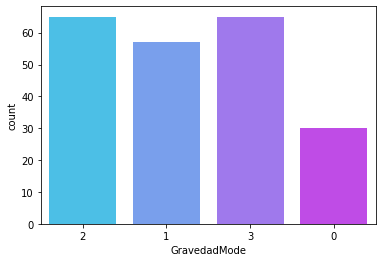

In [ ]:
# Number of observations in each category for 'Modo de Gavedad'
sns.countplot(x='GravedadMode', data=dataset2, palette='cool')
dataset2['GravedadMode'].value_counts()

In [ ]:
#Number of special characters for each instance 

dataset['money'] = dataset['Item (Texto)'].str.count('\\$')
dataset['percentages'] = dataset['Item (Texto)'].str.count('\\%')
dataset['digits'] = dataset['Item (Texto)'].str.count('\\d')
dataset['quotes'] = dataset['Item (Texto)'].str.count('\\"')
dataset['dashes'] = dataset['Item (Texto)'].str.count('\\-')
dataset['parentheses'] = dataset['Item (Texto)'].str.count('\\(')
dataset.head()

,Item (Texto),Gravedad,Sesgo,GravedadMode,SesgoMode,money,percentages,digits,quotes,dashes,parentheses
0,"Las protestas, sin precedentes, ya completan c...","2,2,2,2,3,2,2,2","1,-1,1,1,-1,1,0,0",2,1,0,0,0,0,0,0
1,"Antes rivales irreconciliables en las canchas,...","1,1,2,0,0,2,1,1,1,0","1,0,0,1,0,0,0,0,0",1,0,0,0,4,0,0,0
2,Una patrullera de la Policía Nacional denunció...,"3,3,3,3,3,3,3,3,3","1,1,1,1,1,1,1,1,1",3,1,0,0,2,0,0,0
3,"A simple vista, todo lo que ha dicho Petro es ...","1,0,0,1,1,0,1,1","-1,0,1,1,1,1,1,1",1,1,0,0,0,0,0,0
4,Durante los últimos 26 días desde que se convo...,"3,3,3,3,3,3,3,3,3","0,-1,0,0,0,0,0,0,0",3,0,0,0,13,0,0,4


In [ ]:
def plot_special_chars(mode):
    
    '''Plot the number of special characters for each category'''
    
    fig = plt.subplots(figsize=(18, 10))

    columns = ['digits','quotes', 'parentheses',  'percentages', 'dashes', 'money']

    #  Categorical Data
    a = 2  # number of rows
    b = 3  # number of columns
    c = 1  # initialize plot counter

    for i in columns:
        plt.subplot(a, b, c)
        plt.title('{}, subplot: {}{}{}'.format(i, a, b, c))
        plt.xlabel(i)
        plt.ylabel('Counts')
        sns.barplot(x=dataset[mode].groupby(dataset[i] != 0).value_counts()[1].index, y=dataset[mode].groupby(dataset[i] != 0).value_counts()[1], palette='cool')
        c = c + 1

    plt.show()

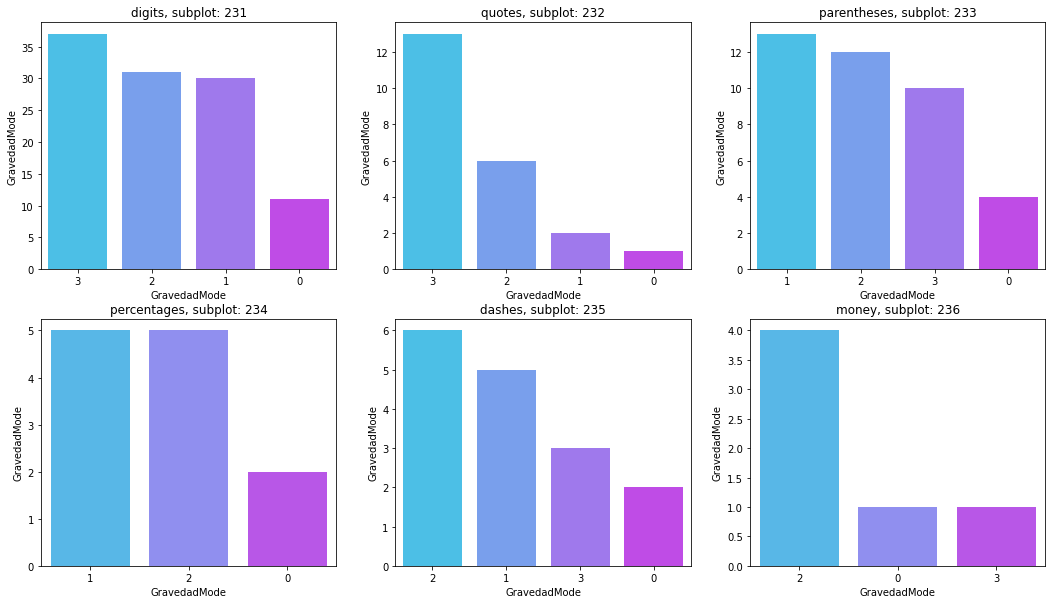

In [ ]:
plot_special_chars('GravedadMode')

---
## **Preprocess Text**

## **Stemmer**

Stemming reduces the words to a common base form.

In [ ]:
!pip install stanza

In [ ]:
import stanza
stanza.download("es")

2021-10-14 20:21:33 INFO: Downloading default packages for language: es (Spanish)...
2021-10-14 20:21:35 INFO: File exists: /root/stanza_resources/es/default.zip.
2021-10-14 20:21:44 INFO: Finished downloading models and saved to /root/stanza_resources.


In [ ]:
nlp = stanza.Pipeline(lang='es', processors='tokenize,mwt,pos,lemma')

2021-10-14 20:21:44 INFO: Loading these models for language: es (Spanish):
| Processor | Package |
-----------------------
| tokenize  | ancora  |
| mwt       | ancora  |
| pos       | ancora  |
| lemma     | ancora  |

2021-10-14 20:21:44 INFO: Use device: cpu
2021-10-14 20:21:44 INFO: Loading: tokenize
2021-10-14 20:21:44 INFO: Loading: mwt
2021-10-14 20:21:44 INFO: Loading: pos
2021-10-14 20:21:45 INFO: Loading: lemma
2021-10-14 20:21:45 INFO: Done loading processors!


## **StopWords**

Remove the most common words from the spanish language. Which are the following:

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [ ]:
nltk.download('stopwords')
sw_nltk = stopwords.words('spanish')

#The word "no" can change the meaning of a sentence. It will probably be important for the n-grams
sw_nltk.remove('no')

# Due to the context of this dataset, these words are also irrelevant: 
sw_nltk.extend(['paro', 'nacional', 'país', 'protesta']) 
print(sw_nltk)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['de', 'la', 'que', 'el', 'en', 'y', 'a', 'los', 'del', 'se', 'las', 'por', 'un', 'para', 'con', 'una', 'su', 'al', 'lo', 'como', 'más', 'pero', 'sus', 'le', 'ya', 'o', 'este', 'sí', 'porque', 'esta', 'entre', 'cuando', 'muy', 'sin', 'sobre', 'también', 'me', 'hasta', 'hay', 'donde', 'quien', 'desde', 'todo', 'nos', 'durante', 'todos', 'uno', 'les', 'ni', 'contra', 'otros', 'ese', 'eso', 'ante', 'ellos', 'e', 'esto', 'mí', 'antes', 'algunos', 'qué', 'unos', 'yo', 'otro', 'otras', 'otra', 'él', 'tanto', 'esa', 'estos', 'mucho', 'quienes', 'nada', 'muchos', 'cual', 'poco', 'ella', 'estar', 'estas', 'algunas', 'algo', 'nosotros', 'mi', 'mis', 'tú', 'te', 'ti', 'tu', 'tus', 'ellas', 'nosotras', 'vosotros', 'vosotras', 'os', 'mío', 'mía', 'míos', 'mías', 'tuyo', 'tuya', 'tuyos', 'tuyas', 'suyo', 'suya', 'suyos', 'suyas', 'nuestro', 'nuestra', 'nuestros', 'nuestras', 'vuestr

In [ ]:
def preprocess_text(sen):

    # Remove punctuations and numbers
    nopunc = re.sub('[^a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$"%]', ' ', sen)

    #Remove Stop Words
    removestop = [word for word in nopunc.split() if word.lower() not in sw_nltk]
    joinRemovestop = " ".join(removestop)

    #Stemmer
    stemmer = nlp(joinRemovestop)
    joinStemmer = " ".join([f'{word.lemma}' for sent in stemmer.sentences for word in sent.words])

    return joinStemmer

## **Words in each category**

A Word Cloud can be created to display the most common words in the preprocessed texts for each category.

In [ ]:
# Add a column with preprocess text

dataset2['process_text'] = dataset2['Item (Texto)'].map(preprocess_text)
dataset2.head()

,Item (Texto),GravedadMode,SesgoMode,process_text
0,"Las protestas, sin precedentes, ya completan c...",2,1,protesta precedente completar casi mes salir c...
1,"Antes rivales irreconciliables en las canchas,...",1,0,rival irreconciliable cancha hoy compañero soc...
2,Una patrullera de la Policía Nacional denunció...,3,1,patrullera Policía denunciar jueves violado va...
3,"A simple vista, todo lo que ha dicho Petro es ...",1,1,simple vista dicho Petro claramente exageració...
4,Durante los últimos 26 días desde que se convo...,3,0,último día convocar negativo directriz Gobiern...


In [ ]:
def categoryWordcloud(names, mode):
    
    '''Plot a Word Cloud for each category'''
    
    # Categories according to mode
    words = ['words_'+str(i) for i in range(len(names))]
    
    # Extract the words for each category
    for j in range(len(names)):
        #words[j] = [i for i in data[data[mode]==str(j)]['process_text']]
        words[j] = [i for i in dataset2['process_text'].loc[dataset2[mode]==str(j)] ]
      
    # Create the Word Clouds
    plt.figure(figsize = (22,8))

    for i in range(len(names)):
    
        wordcloud = WordCloud(width=1024,height=1024,background_color="white").generate(" ".join(words[i]))
    
        plt.subplot(2, 2, i+1)
        plt.title('{}, subplot: {}{}{}'.format(names[i], 2,2,i+1))
        plt.imshow(wordcloud)
        plt.axis('off')


    plt.tight_layout()
    

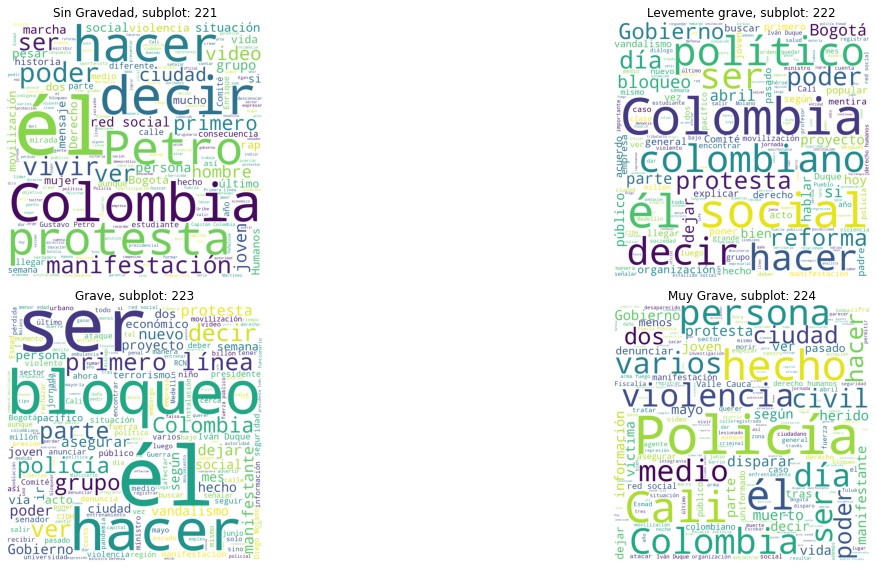

In [ ]:
categoryWordcloud(names = ['Sin Gravedad','Levemente grave', 'Grave', 'Muy Grave'], mode = 'GravedadMode')

## **Train and Test sets**

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Split the data into Train and Test sets

X_train_grav, X_test_grav, y_train_grav, y_test_grav = train_test_split(dataset2['process_text'], dataset2['GravedadMode'], test_size = 0.2, random_state = 0)
print('X_train_grav size:', X_train_grav.shape)
print('y_train_grav size:', y_train_grav.shape)
print('X_test_grav size:', X_test_grav.shape)
print('y_test_grav size:', y_test_grav.shape)
X_train_grav.head()

X_train_grav size: (173,)
y_train_grav size: (173,)
X_test_grav size: (44,)
y_test_grav size: (44,)


189    Gustavo Petro instigar no rechazar violencia E...
146    cumplir dos mes inicio Colombia Bogotá vivir h...
130    objetivo organización social indígena campesin...
22     varios organización nacional internacional ale...
181    empatía víctima asesinato joven Santiago Muril...
Name: process_text, dtype: object

In [ ]:
# An instance before being pre-processed
dataset2['Item (Texto)'].iloc[2]

'Una patrullera de la Policía Nacional denunció este jueves que fue violada por vándalos en Cali, Valle del Cauca. La oficial se encontraba en labores de seguridad durante las manifestaciones del pasado 29 de abril cuando ocurrieron los hechos. Había sido asignada para brindar seguridad en un sector al oriente de Cali. En medio de los actos vandálicos, ella ingresó al CAI para protegerse. Pero los vándalos la emprendieron contra las instalaciones y lo prendieron fuego. Allí, esta mujer empezó a vivir los momentos más duros de su vida.'

In [ ]:
# The same instance now preprocessed 
X_train_grav[2]

'patrullera Policía denunciar jueves violado vanda el Cali Valle Cauca oficial encontrar labor seguridad manifestación pasado abril ocurrir hecho ser asignar brindar seguridad sector oriente Cali medio acto vandá¡lico ingresar CAI proteger él vanda él emprender instalación prender fuego allí mujer empezar vivir momento duro vida'

## **Vectorization**

`CountVectorize` Converts the document collection to a series of token counts. 
A sparse matrix is created: 
- Each row is a document 
- Each column is a word from the vocabulary word. 
- The Entries are the number of times the word appears in each document.
- Trigrams and bigrams are used.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
vect = CountVectorizer(min_df=2, ngram_range = (1,3), lowercase = False, token_pattern = '"|[a-zA-ZáéíóúüÁÉÍÓÚÜñÑ$%-]+').fit(X_train_grav)
X_train_vect_grav = vect.transform(X_train_grav)
X_test_vect_grav = vect.transform(X_test_grav)
feature_names = np.array(vect.get_feature_names())
feature_names[::50]

array(['"', 'Central Unitaria', 'Federación', 'Margarita',
       'República Iván Duque', 'acto vandá', 'anterior', 'bando', 'casa',
       'completar', 'creación', 'defensor', 'devolver', 'elección',
       'estigmatizar', 'formar corazón acercar', 'guerrilla', 'incinerar',
       'jornada', 'lunes', 'mejor', 'mujer', 'ocurrir', 'paz',
       'policía lado', 'privado', 'reapertura', 'resto', 'si no',
       'territorio', 'usar', 'violento'], dtype='<U34')

## **TF-IDF (Term Frequency times inverse document frequency)**: 

It allows to reduce the weightage of the most common words which occurs in all document. That is, the more common across documents, the lower its score, and the more unique a word is, the higher the score.

**TF:** Term Frequency, which measures how frequently a term occurs in a document. 

    TF(t) =  Number of times term t appears in a document / Total number of terms in the document

**IDF:** Inverse Document Frequency, which measures how important a term is. While computing TF, all terms are considered equally important. However it is known that certain terms may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones:

    IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

In [ ]:
tfid = TfidfTransformer(use_idf = True)
X_train_tfidf_grav = tfid.fit_transform(X_train_vect_grav)
X_test_tfidf_grav = tfid.fit_transform(X_test_vect_grav)
print(f"Shape train set: {X_train_tfidf_grav.shape}. Shape test set: {X_test_tfidf_grav.shape}")

Shape train set: (173, 1579). Shape test set: (44, 1579)


In [ ]:
# print idf values 
df_idf = pd.DataFrame(tfid.idf_, index=vect.get_feature_names(),columns=["idf_weights"])
df_idf.sort_values(by=['idf_weights'], ascending=False)

,idf_weights
único,4.806662
especialmente,4.806662
entrenar,4.806662
entrevista,4.806662
población colombiano,4.806662
...,...
Policía,2.504077
dejar,2.408767
social,2.321756
Colombia,2.241713


## **Selector K**

Statistical tests can be used to select those features that have the strongest relationship with the output variable.

The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.

In this method, we calculate the chi-square metric between the target and the numerical variable and only select the desired number of variable with the best chi-squared values.

In [ ]:
from sklearn.feature_selection import SelectKBest

In [ ]:
selector = SelectKBest(score_func=chi2, k=1000)
selector.fit(X_train_tfidf_grav, y_train_grav)

X_train_features_grav = selector.transform(X_train_tfidf_grav)
X_test_features_grav = selector.transform(X_test_tfidf_grav)

X_train_features_grav.shape, X_test_features_grav.shape

((173, 1000), (44, 1000))

## **Data reduction for visualization**

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

def data_reduction(X_train, y_train):
    reduced_data = TruncatedSVD(n_components=2, n_iter=7, random_state=42)
    reduced_data = reduced_data.fit_transform(X_train)

    colors = ['magenta','blue','turquoise','orange']
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    for i in range(y_train.shape[0]):
        ax.scatter(reduced_data[i, 0], reduced_data[i, 1], c=colors[int(y_train.reset_index(drop=True)[i])], alpha=0.6)


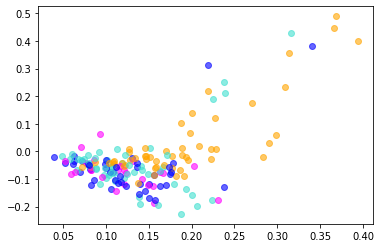

In [ ]:
data_reduction(X_train_features_grav, y_train_grav)

## **Model**

## **Logistic Regression**

- **Regularization** 
Through a constant, it reduces the weight of some of the terms of the function by increasing its cost.
    - Leads to small values for the parameters.
    - Leads to a simpler hypothesis (if it is very large, it can cause a misfit by simplifying the cost function)


- **C**: Is the inverse of regularization strength. Smaller values specify stronger regularization.

In [ ]:
#model
logistic_model = LogisticRegression(C=10, solver='lbfgs', max_iter=100).fit(X_train_features_grav, y_train_grav)

#predict
y_pred_grav = logistic_model.predict(X_test_features_grav)

# Sort the coefficients from the model
sorted_coef_index = logistic_model.coef_[0].argsort()
print('Coefs:\n{}\n'.format(feature_names[sorted_coef_index[:20]]))

Coefs:
['"' 'ganar' 'documentar' 'ESMAD' 'ejemplo' 'bloqueo' 'Jardín' 'Educación'
 'encontrar cerca' 'manera pacífico' 'desgaste' 'colombiano' 'Antioquia'
 'café' 'entrevista' 'gas vencido' 'evitar' 'bajar' 'llegar' 'mayo civil']



## **Metrics**

- **Precision:** Measures how many of the samples predicted as positive are actually positive.
   - It is the probability that a randomly retrieved data is relevant.
   - To limit the number of false positives.
   - If the precision value is equal to one, it will be understood that all the retrieved documents are relevant.

    $$\text{Precisión} = \frac{TP}{TP + FP}$$

- **Recall:** It is the proportion of relevant data retrieved, compared to the total of the data that are relevant existing in the database.
   - Allows you to limit false negatives.
   - If the result is 1, it indicates that all relevant documents that resided in the database have been found.

     $$\text{Exhaustividad} = \frac{TP}{TP + FN}$$

- **f-Score** Is the harmonic mean between precision and Recall.

$$f = 2  \frac{\text{Precisión}*\text{Exhaustividad}}{\text{Precisión}+\text{Exhaustividad}}$$

- The Macro F1-score is defined as the mean of class-wise/label-wise F1-scores.

In [ ]:
def heatmap_confusion_matrix(y_test, y_pred, labels):
    
    '''Creates the confusion matrix and the classification report'''
    
    confusion = confusion_matrix(y_test, y_pred)
 
    sns.heatmap(confusion.T, square=True, annot=True, fmt='d', cbar=False, cmap="Blues",
            xticklabels=labels, yticklabels=labels)
    plt.xlabel('True label')
    plt.ylabel('Predicted label')
    
    print(classification_report(y_test, y_pred, target_names=labels))
    
    return confusion

In [ ]:
# Misclassification

def misclassified(confusion):
    return np.triu(confusion).sum()-np.trace(confusion) + np.tril(confusion).sum()-np.trace(confusion)

              precision    recall  f1-score   support

     NoGrave       1.00      0.20      0.33         5
        Leve       0.92      0.79      0.85        14
       Grave       0.56      0.69      0.62        13
    MuyGrave       0.60      0.75      0.67        12

    accuracy                           0.68        44
   macro avg       0.77      0.61      0.62        44
weighted avg       0.74      0.68      0.67        44

Number of observations misclassified: 14


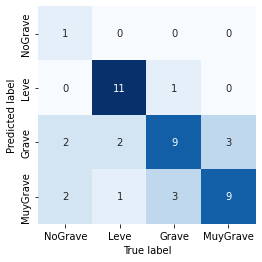

In [ ]:
# Metrics: Confusion Matrix 
confusion_grav = heatmap_confusion_matrix(y_test_grav, y_pred_grav, ['NoGrave', 'Leve', 'Grave', 'MuyGrave'])
print('Number of observations misclassified:', misclassified(confusion_grav))

## **Doc2Vec**

Now instead of TF-IDF I use Doc2Vec. This is a model that represents each document as a vector and relates to the relationship between the words, rather than their presence or not in an instance.

In [ ]:
from gensim.models import doc2vec
from gensim.models.doc2vec import TaggedDocument
from gensim.models import Doc2Vec
from sklearn import utils
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

In [ ]:
def label_sentences(corpus, label_type):
    """
    Gensim's Doc2Vec implementation requires each text to have a label associated with it.
    """
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled



In [ ]:
X_train_d2v_grav = label_sentences(X_train_grav, 'Train')
X_test_d2v_grav = label_sentences(X_test_grav, 'Test')
X_train_d2v_grav[1]

TaggedDocument(words=['cumplir', 'dos', 'mes', 'inicio', 'Colombia', 'Bogotá', 'vivir', 'hecho', 'violencia', 'vandalismo', 'dejar', 'daño', 'sistema', 'transporte', 'público', 'ciudad', 'persona', 'lesionado', 'capturado'], tags=['Train_1'])

## **Distributed Bag of Words (DBOW)**

The paragraph vectors are obtained by training a neural network on the task of predicting a probability distribution of words in a paragraph given a randomly-sampled word from the paragraph.

- vector_size: Dimensionality of the feature vectors.
- min_count: Ignores all words with total frequency lower than this.
- negative: If > 0, negative sampling will be used, the int for negative specifies how many “noise words” should be drawn (usually between 5-20). If set to 0, no negative sampling is used.
- dm: Defines the training algorithm. If dm=1, ‘distributed memory’ (PV-DM) is used. Otherwise, distributed bag of words (PV-DBOW) is employed.
- alpha: The initial learning rate.
- min_alpha: Learning rate will linearly drop to min_alpha as training progresses.

In [ ]:
# Corpus
all_data_grav = X_train_d2v_grav + X_test_d2v_grav

# Model Doc2Vec 
model_dbow_grav = Doc2Vec(dm=0, vector_size=1000, negative=5, min_count=1, alpha=0.095, min_alpha=0.065)
model_dbow_grav.build_vocab([x for x in tqdm(all_data_grav)])

100%|██████████| 217/217 [00:00<00:00, 717229.29it/s]


## **Training** 

Training by changing the 'alpha' learning rate. `alpha` is the initial learning rate, it will drop linearly to min_alpha as training progresses`

In [ ]:
for epoch in range(30):
    model_dbow_grav.train(utils.shuffle([x for x in tqdm(all_data_grav)]), 
                          total_examples = model_dbow_grav.corpus_count, 
                          epochs = model_dbow_grav.epochs)
    
    model_dbow_grav.alpha -= 0.002
    model_dbow_grav.min_alpha = model_dbow_grav.alpha

100%|██████████| 217/217 [00:00<00:00, 777917.92it/s]


In [ ]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [ ]:
train_vectors_dbow_grav = get_vectors(model_dbow_grav, len(X_train_grav), 1000, 'Train')
test_vectors_dbow_grav = get_vectors(model_dbow_grav, len(X_test_grav), 1000, 'Test')
print(f'Shape of data {len(train_vectors_dbow_grav), len(train_vectors_dbow_grav[0])}')

Shape of data (173, 1000)


In [ ]:
# What words are most similar in context to the word 'autodefensa'?
model_dbow_grav.wv.most_similar('autodefensa')

[('ojalá', 0.11063824594020844),
 ('enternecer', 0.10894732177257538),
 ('ánimo', 0.0982668474316597),
 ('refugiar', 0.09700316190719604),
 ('correazo', 0.09581475704908371),
 ('convencido', 0.0932866781949997),
 ('acceso', 0.09050317108631134),
 ('Acuerdo', 0.08845359086990356),
 ('Yohana', 0.08631215989589691),
 ('indebido', 0.08606483042240143)]

              precision    recall  f1-score   support

     NoGrave       0.00      0.00      0.00         5
        Leve       0.58      0.50      0.54        14
       Grave       0.47      0.69      0.56        13
    MuyGrave       0.58      0.58      0.58        12

    accuracy                           0.52        44
   macro avg       0.41      0.44      0.42        44
weighted avg       0.48      0.52      0.50        44

Number of observations misclassified: 21


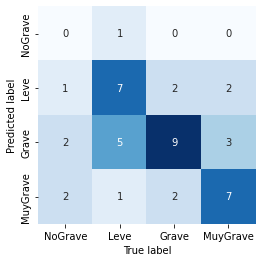

In [ ]:
#model
logistic_model = LogisticRegression(C=0.1, multi_class='multinomial', solver='lbfgs', max_iter=800).fit(train_vectors_dbow_grav, y_train_grav)

#predict
y_pred_grav = logistic_model.predict(test_vectors_dbow_grav)

# Metrics
confusion_grav = heatmap_confusion_matrix(y_test_grav, y_pred_grav, ['NoGrave', 'Leve', 'Grave', 'MuyGrave'])
print('Number of observations misclassified:', misclassified(confusion_grav))

## **Distributed Memory**

Distributed Memory (DM) acts as a memory that remembers what is missing from the current context — or as the topic of the paragraph. While the word vectors represent the concept of a word, the document vector intends to represent the concept of a document.

In [ ]:
def doc2vec_training(model, all_data, vector_size, X_train, X_test, y_train, epochs_):

    for epoch in range(epochs_):
        
        model.train(utils.shuffle([x for x in tqdm(all_data)]), 
                            total_examples = model.corpus_count, 
                            epochs = model.epochs)
        model.alpha -= 0.002
        model.min_alpha = model.alpha
    
    train_vectors = get_vectors(model, len(X_train), vector_size, 'Train')
    test_vectors = get_vectors(model, len(X_test), vector_size, 'Test')
    
    return train_vectors, test_vectors

In [ ]:
# Model

model_dm_grav = Doc2Vec(dm=1, dm_mean=1, window=10, negative=5, workers=5, vector_size=1000, min_count=1, alpha=0.065, min_alpha=0.065)
model_dm_grav.build_vocab(all_data_grav)

In [ ]:
# Train

train_vectors_dm_grav, test_vectors_dm_grav = doc2vec_training(model=model_dm_grav, 
                                                               all_data=all_data_grav, 
                                                               vector_size=1000, 
                                                               X_train = X_train_grav, 
                                                               X_test = X_test_grav, 
                                                               y_train = y_train_grav, 
                                                               epochs_=30)

100%|██████████| 217/217 [00:00<00:00, 1162406.09it/s]


In [ ]:
# What words are most similar in context to the word 'vándalo'?
model_dm_grav.wv.most_similar('vándalo')

[('agresor', 0.9115383625030518),
 ('victimizar', 0.8691256046295166),
 ('buen', 0.5928888320922852),
 ('quedar', 0.5804457664489746),
 ('derivado', 0.5489126443862915),
 ('comunicación', 0.5479405522346497),
 ('chapa', 0.5275713205337524),
 ('mediático', 0.5192398428916931),
 ('ambiente', 0.5032200217247009),
 ('extensión', 0.49399876594543457)]

              precision    recall  f1-score   support

     NoGrave       0.00      0.00      0.00         5
        Leve       0.38      0.21      0.27        14
       Grave       0.45      0.69      0.55        13
    MuyGrave       0.38      0.42      0.40        12

    accuracy                           0.39        44
   macro avg       0.30      0.33      0.30        44
weighted avg       0.36      0.39      0.36        44

Number of observations misclassified: 27


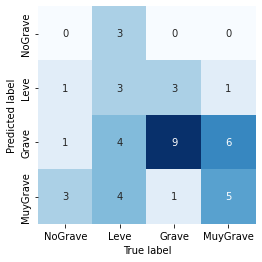

In [ ]:
# Logistic regression model
logistic_model = LogisticRegression(C=100, multi_class='multinomial', solver='lbfgs', max_iter=800).fit(train_vectors_dm_grav, y_train_grav)

#predict
y_pred_grav = logistic_model.predict(test_vectors_dm_grav)

# Metrics
confusion_grav = heatmap_confusion_matrix(y_test_grav, y_pred_grav, ['NoGrave', 'Leve', 'Grave', 'MuyGrave'])
print('Number of observations misclassified:', misclassified(confusion_grav))

## **Conclusion**
The TF-IDF approach works best for 'Modo de Gravedad'. In this case, the words present in the documents define the seriousness of the news. Apparently it has a limit with an accuracy of 0.68. Also, distributed word bag performs better than distributed memory when working with vectors.